In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab import files

In [18]:
!pip install opendatasets
import opendatasets as od

In [19]:
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


Total Images per Class:
NORMAL: 1585 images
PNEUMONIA: 4275 images


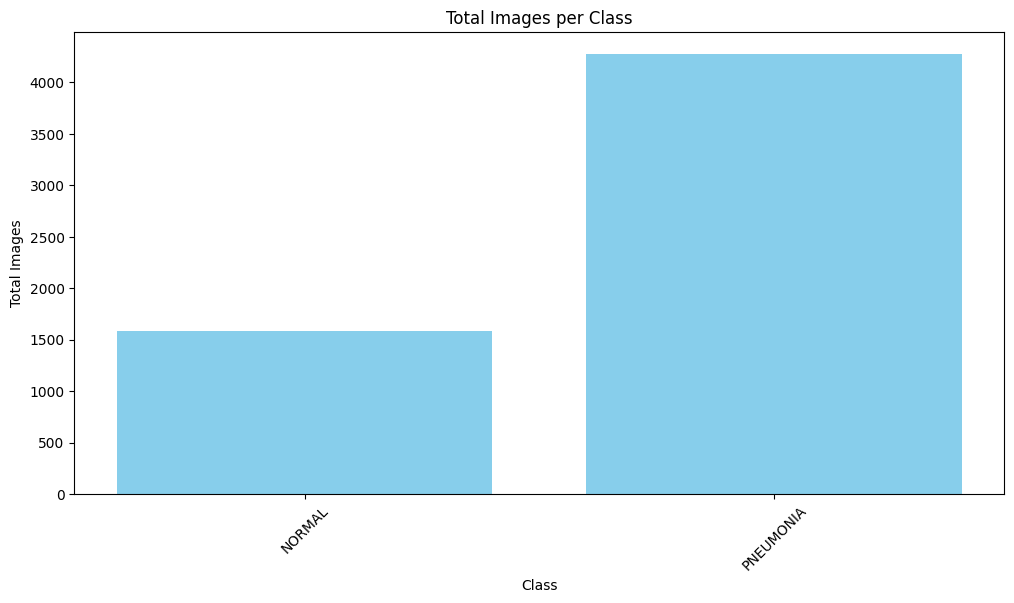

In [20]:
import os
import matplotlib.pyplot as plt

# List of dataset directories
dataset_paths = ['/content/chest-xray-pneumonia/chest_xray/chest_xray/test', '/content/chest-xray-pneumonia/chest_xray/chest_xray/train', '/content/chest-xray-pneumonia/chest_xray/chest_xray/val']

# Initialize a dictionary to store the total number of images for each class
total_images_per_class = {}

# Loop through each dataset directory
for dataset_path in dataset_paths:
    # Loop through each folder in the dataset directory
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)

        if os.path.isdir(folder_path):
            # Count the total number of images in each folder
            total_images = len(os.listdir(folder_path))

            # Add information to the dictionary
            if folder_name in total_images_per_class:
                total_images_per_class[folder_name] += total_images
            else:
                total_images_per_class[folder_name] = total_images

# Print the total number of images for each class
print("Total Images per Class:")
for class_name, total_images in total_images_per_class.items():
    print(f"{class_name}: {total_images} images")

# Display the data in a bar chart
plt.figure(figsize=(12, 6))
plt.bar(total_images_per_class.keys(), total_images_per_class.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Total Images')
plt.title('Total Images per Class')
plt.xticks(rotation=45)
plt.show()


In [21]:
# Define constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
DATA_DIR = '/content/chest-xray-pneumonia/chest_xray/chest_xray/'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flowing from directory for training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR + 'train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    DATA_DIR + 'val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    DATA_DIR + 'test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# Define the base model with pre-trained weights from ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the sequential model
model = tf.keras.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 64)          737344    
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 64)          0         
 D)                                                              
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                        

In [23]:
target = 0.99

class TargetCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= target and logs.get('val_accuracy') >= target:
                print(f"Accuracy and val_accuracy >= {target:.2%} of targets. Training stopped.")
                self.model.stop_training = True

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

callback = TargetCallback()

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[callback, reduce_lr],
    shuffle=True
)

Epoch 1/15
82/82 [==============================] - 86s 982ms/step - loss: 0.3975 - accuracy: 0.8909 - val_loss: 0.7614 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/15
82/82 [==============================] - 68s 828ms/step - loss: 0.1498 - accuracy: 0.9411 - val_loss: 0.4724 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/15
82/82 [==============================] - 67s 818ms/step - loss: 0.1391 - accuracy: 0.9475 - val_loss: 0.6461 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/15
82/82 [==============================] - 67s 818ms/step - loss: 0.1196 - accuracy: 0.9505 - val_loss: 0.3108 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/15
82/82 [==============================] - 67s 818ms/step - loss: 0.1036 - accuracy: 0.9592 - val_loss: 0.4866 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
82/82 [==============================] - 67s 817ms/step - loss: 0.1181 - accuracy: 0.9565 - val_loss: 0.4335 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/15
82/82 [==============================] - 67s 820ms/st

In [26]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 6s 524ms/step - loss: 0.3791 - accuracy: 0.8718
Test Loss: 0.37909793853759766
Test Accuracy: 0.8717948794364929


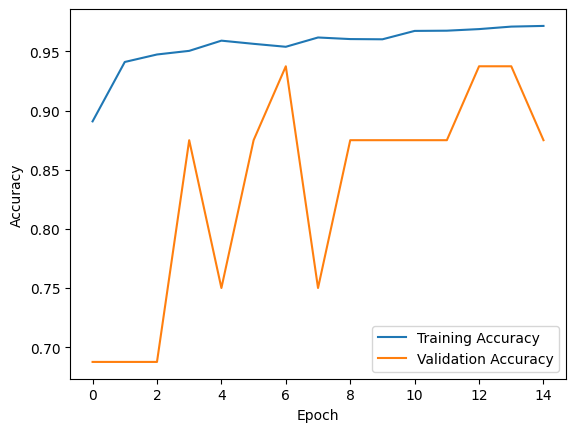

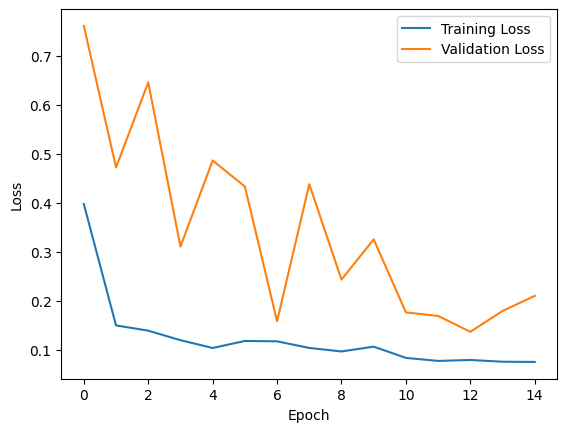

In [24]:
# Plotting model accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Saving Normal1.jpeg to Normal1.jpeg
Saving Normal2.jpeg to Normal2.jpeg
Saving Pneumonia1.jpeg to Pneumonia1.jpeg
Saving Pneumonia2.jpeg to Pneumonia2.jpeg
1/1 [==============================] - 0s 37ms/step


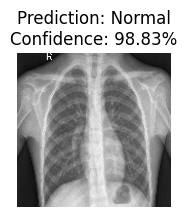

1/1 [==============================] - 0s 35ms/step


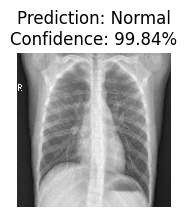

1/1 [==============================] - 0s 44ms/step


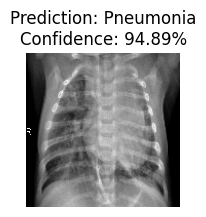

1/1 [==============================] - 0s 31ms/step


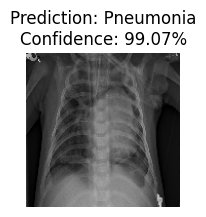

In [37]:
classes = ['Normal', 'Pneumonia']

# Function to predict uploaded images
def predict_uploaded_image(model):
    uploaded_files = files.upload()

    for file_name in uploaded_files.keys():
        img_path = file_name
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)

        plt.figure(figsize=(2, 2))

        if predicted_class_index < len(classes):
            predicted_class = classes[predicted_class_index]
            confidence = np.max(prediction) * 100

            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
            plt.show()
        else:
            print("Sorry, the prediction cannot be determined. The image is outside of the trained categories.")

# Calling the function to predict uploaded images
predict_uploaded_image(model)